# 2. 强度阈值化

结果：将图像从灰度图转换为二值图像。

基本思想：假设图像中有明显的目标和背景，则其灰度直方图呈双峰分布，当灰度级直方图具有双峰特性时，<u>选取两峰之间的谷对应的灰度级作为阈值</u>。

![mode](assets/mode.png)

## 2.1 固定阈值

设置一个特定的阈值。高于阈值的像素将被设置为一个值（白色），而低于阈值的像素将被设置为另一个值（黑色）。


实现步骤：
1. 选择阈值：设定一个灰度级阈值 $T$
2. 应用阈值：对图像中的每个像素 $f(x,y)$ 进行如下操作：
- 如果 $f(x,y)\ge T$，则 $f'(x,y)=MAX$（255，白色）
- 如果 $f(x,y)< T$，则 $f'(x,y)= MIN$（0，黑色）

效果：阈值化后的图像只包含两种颜色，使得图像的某些特征更加突出。





![](images/强度阈值化.png)



函数： `cv2.threshold(src, thresh, maxval, type)`

参数说明：
- 参数1： 原图像
- 参数2： 对像素值进行分类的阈值
- 参数3： 当像素值高于(小于)阈值时，应该被赋予的新的像素值
- 参数4： 第四个参数是阈值方法。

返回值有两个：
1. `ret`：一个整数值，表示阈值操作的结果。对于二值化操作，这个值通常会根据操作类型有所不同：
- 如果成功执行了阈值操作，`ret` 通常为 0。
- 如果遇到错误，`ret` 可能不为 0，具体含义取决于 OpenCV 的实现。
2. `thresholded_img`：处理后的图像，二值化后的结果。



![threshold](assets/fix_threshold.png)

True


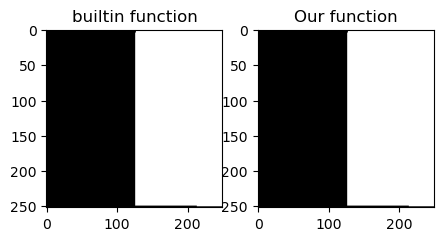

In [49]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# 灰度图读入
img = cv2.imread('./images/thresh.png', 0)
threshold = 127

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
# 阈值分割
_, th = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
plt.imshow(th, cmap='gray');
plt.title('builtin function')

# img > threshold 逻辑判断返回 0-1
img_thresh = (img > threshold) * 255
plt.subplot(1, 2, 2)
plt.imshow(img_thresh, cmap='gray');
plt.title('Our function')

print(np.array_equal(th, img_thresh))  # 判断我们两种方法生成的array是否相等

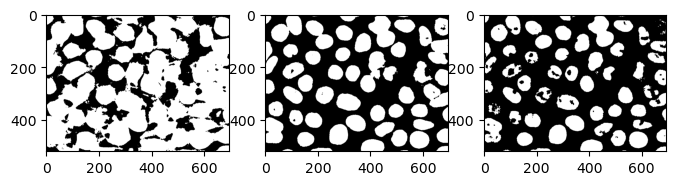

In [41]:
img2 = cv2.imread('images/sample-强度阈值化.png', 0)
thresholds = [50, 80, 100]

plt.figure(figsize=(8, 8))
for i in range(len(thresholds)):
    plt.subplot(1, len(thresholds), i + 1)
    img_thresh = (img2 > thresholds[i])  # * 255
    plt.imshow(img_thresh, cmap='gray')

结果极大地依赖于阈值的设定
- 阈值过小：图像偏白
- 阈值过大：图像偏黑

小结
- 对比度拉伸的极限情况。
- 生成灰度图像的二值图像。
- 将阈值以下的值设为黑色，将阈值以上（包括阈值）的值设为白色。
- 结果极大地依赖于阈值的设定。

### 练习题

![](images/强度阈值例题.png)

![](images/强度阈值例题答案.png)

### 其他的固定阈值函数

- `THRESH_BINARY`：$\operatorname{det}(x, y)= \begin{cases}\text { maxval } & \text { if } \operatorname{src}(x, y)>\text { thresh } \\ 0 & \text { otherwise }\end{cases}$
- `THRESH_BINARY_INV`：$\operatorname{dst}(x, y)= \begin{cases}0 & \text { if } \operatorname{arc}(x, y)>\text { threshold } \\ \text { maxval } & \text { otherwise }\end{cases}$
- `THRESH_TRUNC`：$\operatorname{dst}(x, y)= \begin{cases}\operatorname{threshold} & \text { if } \operatorname{src}(x, y)>\operatorname{threshold} \\ \operatorname{src}(x, y) & \text { otherwise }\end{cases}$
- `THRESH_TOZERO`：$\operatorname{dst}(x, y)= \begin{cases}\operatorname{src}(x, y) & \text { if } \operatorname{src}(x, y)>\operatorname{threshold} \\ 0 & \text { otherwise }\end{cases}$
- `THRESH_TOZERO_INV`：$\operatorname{dst}[x, y)= \begin{cases}0 & \text { if } \operatorname{src}(x, y)>\text { threshold } \\ \operatorname{src}(x, y) & \text { otherwise }\end{cases}$

### 固定阈值不同方法比较

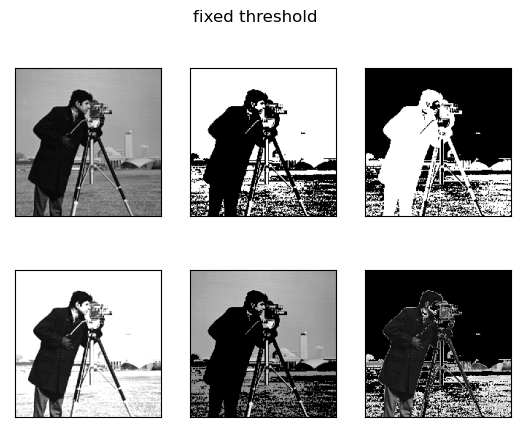

In [5]:
#导入第三方包
import cv2
from matplotlib import pyplot as plt

# 
#opencv读取图像
img = cv2.imread('./images/person.png', 0)
# 5 种阈值法图像分割
_, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
_, thresh3 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
_, thresh4 = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO)
_, thresh5 = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO_INV)

images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
#使用for循环进行遍历，matplotlib进行显示
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.suptitle('fixed threshold')
plt.show()

## 2.2 自动阈值

### 2.2.1 Isodata 迭代法阈值

步骤

1. 求出图象的最大灰度值和最小灰度值，分别记为 $Z_{\max}$ 和 $Z_{\min}$，令初始阈值 $T_0=(Z_{\max}+Z_{\min})/2$；
2. 根据阈值 $T_K$ 将图象分割为前景和背景，分别求出两者的平均灰度值 $Z_O$ 和 $Z_B$ ；
3. 求出新阈值 $T_{K+1}=(Z_O+Z_B)/2$；
4. 若 $T_K==T_{K+1}$，则所得即为阈值；否则转 2，迭代计算；
5. 使用计算后的阈值进行固定阈值分割。

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
120.0


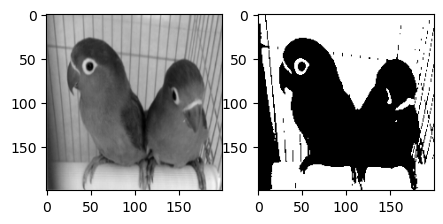

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def best_thresh(img):
    img_array = np.array(img).astype(np.float32)  # 将图像转化为数组并转换为浮点型
    I = img_array  # 赋值给I变量
    zmax = np.max(I)  # 找到图像的最大灰度值
    zmin = np.min(I)  # 找到图像的最小灰度值
    tk = (zmax + zmin) / 2  # 设置初始阈值为最大值和最小值的平均值
    # 根据阈值将图像分割为前景和背景，分别求出两者的平均灰度值
    b = 1  # 标志变量，用于控制循环
    m, n = I.shape  # 获取图像的尺寸（行数和列数）
    while b == 0:  # 当b等于0时退出循环
        ifg = 0  # 前景像素计数器初始化
        ibg = 0  # 背景像素计数器初始化
        fnum = 0  # 前景像素灰度总和初始化
        bnum = 0  # 背景像素灰度总和初始化
        for i in range(1, m):  # 遍历图像的每一行
            for j in range(1, n):  # 遍历图像的每一列
                tmp = I(i, j)  # 获取当前像素的灰度值
                if tmp >= tk:  # 如果像素值大于等于当前阈值
                    ifg = ifg + 1  # 增加前景像素计数
                    fnum = fnum + int(tmp)  # 累加前景像素灰度值
                else:  # 否则归为背景
                    ibg = ibg + 1  # 增加背景像素计数
                    bnum = bnum + int(tmp)  # 累加背景像素灰度值
        # 计算前景和背景的平均灰度值
        zo = int(fnum / ifg)  # 计算前景的平均灰度值
        zb = int(bnum / ibg)  # 计算背景的平均灰度值
        if tk == int((zo + zb) / 2):  # 如果新阈值和当前阈值相同，退出循环
            b = 0  # 将b置为0，退出循环
        else:
            tk = int((zo + zb) / 2)  # 更新阈值为前景和背景平均值的中间值
    return tk  # 返回最终的阈值


img = cv2.imread("./images/bird.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(gray, (200, 200))  #大小
yvzhi = best_thresh(img)
ret1, th1 = cv2.threshold(img, yvzhi, 255, cv2.THRESH_BINARY)
print(ret1)
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(th1, cmap='gray')
plt.show()

### 2.2.2 Otsu大津法

最大类间方差法， 1979年日本学者大津提出，是一种基于<u>全局阈值</u>的自适应方法。

灰度特性：图像分为前景和背景。当取最佳阈值时，两部分之间的差别应该是最大的，衡量差别的标准为最大类间方差。

直方图有两个峰值的图像，大津法求得的Ｔ近似等于两个峰值之间的低谷。

![](assets/otsu.png)



$$
\begin{align}
\omega_1&=\frac{N_1}{M \times N} \\
\omega_2&=\frac{N_2}{M \times N} \\
N_1+N_2&=M \times N \\
\omega_1+\omega_2&=1 \\
\mu&=\mu_1 \times \omega_1+\mu_2 \times \omega_2 \\
g&=\omega_1 \times\left(\mu-\mu_1\right)^2+\omega_2 \times\left(\mu-\mu_2\right)^2
\end{align}
$$
得到等价公式
$$
g=\omega_1 \times \omega_2 \times\left(\mu_1-\mu_2\right)^2
$$

等价于最小类内方差 $\omega_1\sigma_1^2+\omega_2\sigma_2^2$

符号说明

- T：图像 $I(x,y)$ 前景和背景的分割阈值
- $\omega_1$：属于前景的像素点数占整幅图像的比例记，其平均灰度 $\mu_1$
- $\omega_2$：背景像素点数占整幅图像的比例为，其平均灰度为 $\mu_2$
- $\mu$：图像的总平均灰度
- $g$：类间方差
- $N_1$：设图像的大小为 $M\times N$，图像中像素的灰度值小于阈值 $T$ 的像素个数
- $N_2$：像素灰度大于阈值 $T$ 的像素个数
- $\sigma$：强度方差

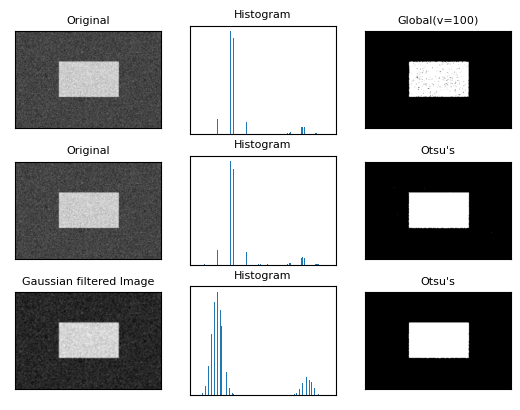

In [8]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('./images/noisy.png', 0)
# 固定阈值法
ret1, th1 = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
# Otus 阈值法
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 先进行高斯滤波，再使用Otsu阈值法
blur = cv2.GaussianBlur(img, (5, 5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
images = [img, 0, th1, img, 0, th2, blur, 0, th3]
titles = ['Original', 'Histogram', 'Global(v=100)',
          'Original', 'Histogram', "Otsu's",
          'Gaussian filtered Image', 'Histogram', "Otsu's"]

for i in range(3):
    # 绘制原图
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i * 3], 'gray')
    plt.title(titles[i * 3], fontsize=8)
    plt.xticks([]), plt.yticks([])

    # 绘制直方图plt.hist, ravel函数将数组降成一维
    plt.subplot(3, 3, i * 3 + 2)
    plt.hist(images[i * 3].ravel(), 256)
    plt.title(titles[i * 3 + 1], fontsize=8)
    plt.xticks([]), plt.yticks([])

    # 绘制阈值图
    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(images[i * 3 + 2], 'gray')
    plt.title(titles[i * 3 + 2], fontsize=8)
    plt.xticks([]), plt.yticks([])
plt.show()

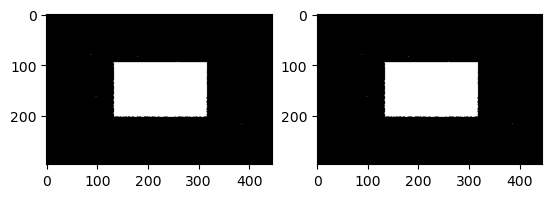

In [2]:
#Otsu源码
import numpy as np


def OTSU_enhance(img_gray, th_begin=0, th_end=256, th_step=1):
    #"must input a gary_img"
    assert img_gray.ndim == 2  # 确保输入图像是灰度图

    max_g = 0  # 初始化最大类间方差
    suitable_th = 0  # 初始化最佳阈值
    for threshold in range(th_begin, th_end, th_step):  # 遍历所有可能的阈值
        bin_img = img_gray > threshold  # 获取前景（大于阈值的部分）
        bin_img_inv = img_gray <= threshold  # 获取背景（小于等于阈值的部分）
        fore_pix = np.sum(bin_img)  # 计算前景像素的数量
        back_pix = np.sum(bin_img_inv)  # 计算背景像素的数量
        if 0 == fore_pix:  # 如果前景像素为0，直接跳出循环
            break
        if 0 == back_pix:  # 如果背景像素为0，跳过当前阈值
            continue

        w0 = float(fore_pix) / img_gray.size  # 计算前景像素占总像素的比例
        u0 = float(np.sum(img_gray * bin_img)) / fore_pix  # 计算前景的平均灰度值
        w1 = float(back_pix) / img_gray.size  # 计算背景像素占总像素的比例
        u1 = float(np.sum(img_gray * bin_img_inv)) / back_pix  # 计算背景的平均灰度值
        # 类间方差
        g = w0 * w1 * (u0 - u1) * (u0 - u1)  # 计算类间方差
        if g > max_g:  # 如果当前类间方差大于最大值，则更新最大值和对应的阈值
            max_g = g
            suitable_th = threshold
    return suitable_th  # 返回最佳阈值


img = cv2.imread('images/noisy.png', 0)
thresh = OTSU_enhance(img)
ret1, th1 = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.subplot(1, 2, 1)
a = plt.imshow(th1, cmap='gray')
plt.subplot(1, 2, 2)
b = plt.imshow(th2, cmap='gray')
plt.show(b)


### 2.2.3 Triangle 方法

三角形方法是一种基于图像直方图的自动阈值选择方法。它使用直方图中最高峰与最远边界之间的最大距离确定最佳阈值。

适合于直方图是单峰的图片

![](images/triangle.png)

步骤：
1. 寻找直方图峰值
- 确定直方图的峰值点 $(r_p,h_p)$，这是直方图中最高的点，其中 $r_p$ 是灰度级，$h_p$ 是该灰度级的频数。

2. 构建直线
- 从直方图的峰值点到最高灰度级点 $(r_m,h_m)$ 构建一条直线 $l(r)$。
- $r_m$ 通常是直方图中的最大灰度级（255），$h(m)$ 是该灰度级的频数。

3. 计算最大距离:
- 计算直方图中每个灰度级 $r$ 与直线 $l(r)$ 之间的垂直距离 $d(r)$。
- 找到这些距离中的最大值，相应的灰度级 $r$ 就被确定为分割阈值。


理解 $d(r)$

- 直方图中的峰值代表图像中最常见的亮度（通常是背景或主要对象），而直线 $l(r)$ 则代表从最常见的亮度过渡到最亮或最暗亮度的一种理想化线性变化。
- 直方图中的每个点到这条直线的垂直距离 $d(r)$ 反映了实际直方图与这种理想化过渡的偏差。
- 最大的垂直距离表示直方图中背景与前景之间最明显的分界线，因此该点对应的灰度级被选为阈值，用于将图像分割成前景和背景。


#### opencv 实现
将第四个type参数设置为 `cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE`
- `cv2.THRESH_TRIANGLE`：直接调用三角形阈值法。
- `cv2.THRESH_BINARY`：应用二值化。

第二个阈值参数设为 `0`，意味着 OpenCV 会根据图像自动计算适当的阈值。

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


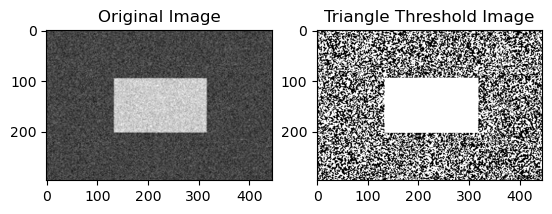

In [1]:
import cv2
import matplotlib.pyplot as plt

# 读取灰度图像
image = cv2.imread('images/noisy.png', cv2.IMREAD_GRAYSCALE)

# 使用三角形阈值法
_, triangle_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)

# 显示原始图像和使用三角形阈值法分割后的图像
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(triangle_threshold, cmap='gray')
plt.title('Triangle Threshold Image')
plt.show()



#### 手动实现

步骤
1. **计算直方图**：使用 `cv2.calcHist` 计算灰度图像的直方图。
2. **寻找峰值**：通过 `np.argmax(hist)` 找到直方图中的最高峰。
3. **计算直线**：通过比较峰值到两边界的距离，选择适当的端点，计算从峰值到端点的直线。
4. **计算距离**：对每个灰度值，计算它到直线的距离，并找到距离最大的点，作为阈值。
5. **图像分割**：使用 `cv2.threshold` 根据计算出的阈值进行图像分割。

这个实现将使用三角形方法自动计算图像的最佳阈值，并生成二值化后的图像。

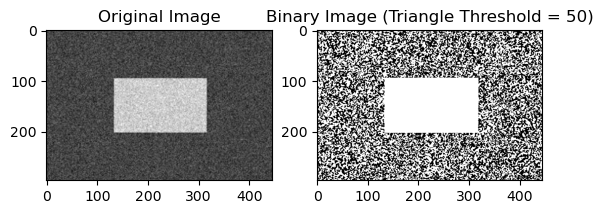

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像并转换为灰度图像
image = cv2.imread('images/noisy.png', cv2.IMREAD_GRAYSCALE)

# 计算图像的直方图
hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()

# 找到直方图的峰值位置
peak_index = np.argmax(hist)
max_value = hist[peak_index]

# 找到直方图的边界值（灰度值为0或255的端点）
left_bound = np.min(np.where(hist > 0))
right_bound = np.max(np.where(hist > 0))

# 计算从峰值到边界的直线的斜率
if (peak_index - left_bound) > (right_bound - peak_index):
    start, end = left_bound, peak_index
else:
    start, end = peak_index, right_bound


# 定义函数来计算点到直线的距离
def distance_from_line(hist_value, start_value, end_value, start_index, end_index):
    return abs((end_value - start_value) * (hist_value - start_index) -
               (end_index - start_index) * (hist_value - start_value)) / np.sqrt((end_value - start_value) ** 2 + (end_index - start_index) ** 2)


# 找到距离直线最远的点，作为阈值
distances = [distance_from_line(hist[i], hist[start], hist[end], start, end) for i in range(start, end + 1)]
threshold = start + np.argmax(distances)

# 使用计算得到的阈值对图像进行二值化
_, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

# 显示原始图像和二值化图像
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title(f'Binary Image (Triangle Threshold = {threshold})')
plt.show()

## 三种自动阈值法适应场景不同

![](images/ThreeCompare.png)

## 思考题

![](images/ThreeCompareQuestion.png)

下面选项中哪个最适合于这种图片

1. Mean thresholding. （计算整个图像的平均亮度，并将其作为阈值）
2. IsoData thresholding.
3.  Otsu thresholding.
4. Triangle thresholding.


## 拓展：自适应阈值法

函数：`cv2.adaptiveThreshold()`

参数说明：
- 参数1：要处理的原图
- 参数2：最大阈值，一般为255
- 参数3：小区域阈值的计算方式
  - `ADAPTIVE_THRESH_MEAN_C`：小区域内取均值
  - `ADAPTIVE_THRESH_GAUSSIAN_C`：小区域内加权求和，权重是个高斯核
- 参数4：阈值方式（跟前面讲的那5种相同）
- 参数5：小区域的面积，如 11 就是 $11\times11$ 的小块
- 参数6：最终阈值等于小区域计算出的阈值再减去此值

特点：自适应阈值会每次取图片的一小部分计算阈值，这样图片不同区域的阈值就不尽相同，适用于明暗分布不均的图片。

In [ ]:
# 自适应阈值与固定阈值对比
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./images/paper2.png', 0)

# 固定阈值
ret, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
# 自适应阈值
th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 4)
th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 4)
#全局阈值，均值自适应，高斯加权自适应对比
titles = ['Original', 'Global(v = 127)', 'Adaptive Mean', 'Adaptive Gaussian']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i], fontsize=8)
    plt.xticks([]), plt.yticks([])
plt.show()